In [1]:
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from numpy.random import seed
seed(123)

2024-05-10 13:01:41.593062: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.1


# Zad
Porównaj wyniki działań różnych optymalizacji
* 
```python
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)
```
* 
```python
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
```
* 
```python
RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
```
* 
```python
Adagrad = keras.optimizers.Adagrad(learning_rate=0.01)
```
* 
```python
Adadelta = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
```
* 
```python
Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
```
* 
```python
Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
```

https://keras.io/optimizers/

In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()


/var/folders/k_/2tytwy6d2ll1_kvk_k0j7vd00000gn/T/ipykernel_8144/1853370235.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('adult/adult.data', sep=", ",header = None)
/var/folders/k_/2tytwy6d2ll1_kvk_k0j7vd00000gn/T/ipykernel_8144/1853370235.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:




dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

# SGD

In [4]:
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History

history_sgd = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9771 (38.17 KB)
Trainable params: 9771 (38.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
sgd = tf.keras.optimizers.legacy.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

/Users/apple/Projects/UJ_zajecia/venvp/lib/python3.8/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

Epoch 1/100
943/943 [==============================] - 2s 2ms/step - loss: 0.5313 - accuracy: 0.7496 - val_loss: 0.4168 - val_accuracy: 0.7866
Epoch 2/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3576 - accuracy: 0.8309 - val_loss: 0.3414 - val_accuracy: 0.8402
Epoch 3/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3388 - accuracy: 0.8392 - val_loss: 0.3345 - val_accuracy: 0.8452
Epoch 4/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3334 - accuracy: 0.8434 - val_loss: 0.3310 - val_accuracy: 0.8465
Epoch 5/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3299 - accuracy: 0.8449 - val_loss: 0.3287 - val_accuracy: 0.8479
Epoch 6/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3283 - accuracy: 0.8470 - val_loss: 0.3281 - val_accuracy: 0.8463
Epoch 7/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3280 - accuracy: 0.8459 - val_loss: 0.3270 - val_accuracy: 0.8489

In [8]:
history_sgd.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

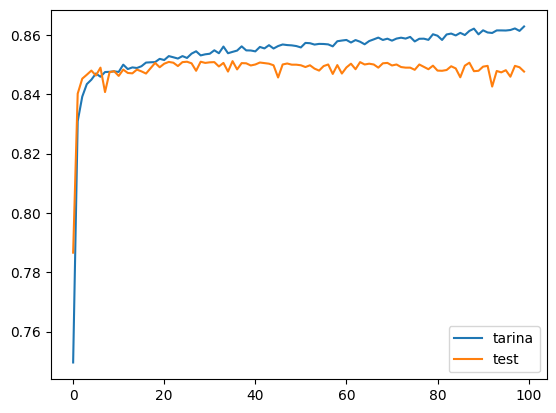

In [9]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

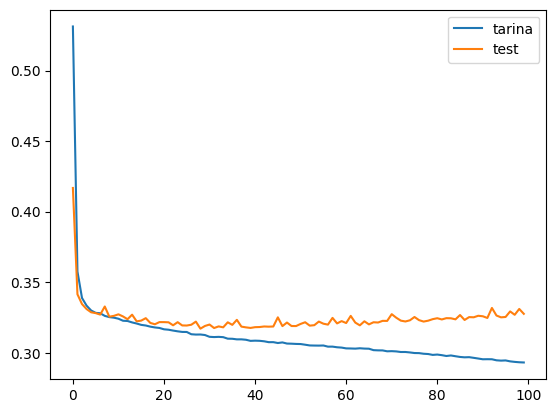

In [10]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['loss'], label = "tarina")
plt.plot(history_sgd.history['val_loss'], label = "test")
plt.legend()
plt.show()

# RMSprop

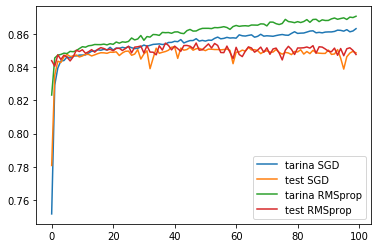

# Adagrad

# Adadelta

# Adam

# Adam